# TODO scrape any car data from ss.com
* clean up prices as numerics
* group by make and model
* plot the data - pricing for sure
* if you do more advanced analysis that also could be used for the final project

* for those who want scraping part of final project
* scrape data from somewhere else - maybe Lithuanian ss.com or wikipedia?

In [76]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Get URL and scrape the data, save to CSV file 

In [2]:
url = "https://www.ss.com/en/transport/cars/audi/"
url


'https://www.ss.com/en/transport/cars/audi/'

In [4]:
req = requests.get(url)  #extracting the html
req.status_code

200

In [5]:
soup = BeautifulSoup(req.text, 'lxml') 
soup.title

<title>SS.COM Cars - Audi, Prices - Advertisements</title>

In [6]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"}) #this will work as long as html has a table row with id head_line
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]]  # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [7]:
column_names = getColList(soup)
column_names  # to be used later when creating our table

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [8]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [9]:
# from row get dictionary with values 
def getRow(row, colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [10]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [11]:
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows)
    

In [12]:
audi_cars = "https://www.ss.com/en/transport/cars/audi/"
idf = getDFfromURL(audi_cars)
idf.head()

,description,url,Model,Year,Volume,Run,Price
0,Tiek pārdots lielisks auto ar 200Kw izcilā teh...,https://ss.com/msg/en/transport/cars/audi/q7/b...,Q7,2015,3.0D,227 thd.,"33,800 €"
1,"Līzings, maina, Individuāls audi, Sedans, Face...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2008,2.8,-,"7,999 €"
2,"Pārdod Audi Q7, 3.0 dīzelis, Automāts\r\n\r\nS...",https://ss.com/msg/en/transport/cars/audi/q7/e...,Q7,2006,3.0D,-,"6,990 €"
3,"Pārdod audi A8/s8, 3.7 benzīns, Automāts\r\n\r...",https://ss.com/msg/en/transport/cars/audi/a8/g...,A8,2003,3.7,-,"3,590 €"
4,"Audi A4 2.0D Kabriolets, automāts, ādas salons...",https://ss.com/msg/en/transport/cars/audi/cabr...,Cabriolet,2008,2.0D,174 thd.,"6,900 €"


# Read CSV file, clean up prices, sort data by model and year

In [13]:
idf.to_csv("audi_sell_list.csv")

In [14]:
audi_df = pd.read_csv("audi_sell_list.csv")
audi_df.head()

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Tiek pārdots lielisks auto ar 200Kw izcilā teh...,https://ss.com/msg/en/transport/cars/audi/q7/b...,Q7,2015,3.0D,227 thd.,"33,800 €"
1,1,"Līzings, maina, Individuāls audi, Sedans, Face...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2008,2.8,-,"7,999 €"
2,2,"Pārdod Audi Q7, 3.0 dīzelis, Automāts\r\n\r\nS...",https://ss.com/msg/en/transport/cars/audi/q7/e...,Q7,2006,3.0D,-,"6,990 €"
3,3,"Pārdod audi A8/s8, 3.7 benzīns, Automāts\r\n\r...",https://ss.com/msg/en/transport/cars/audi/a8/g...,A8,2003,3.7,-,"3,590 €"
4,4,"Audi A4 2.0D Kabriolets, automāts, ādas salons...",https://ss.com/msg/en/transport/cars/audi/cabr...,Cabriolet,2008,2.0D,174 thd.,"6,900 €"


In [15]:
audi_df['Price'] = audi_df['Price'].str.replace(unicodedata.lookup('EURO SIGN'), '')
audi_df['Price'] = audi_df['Price'].str.replace(",", '')

audi_df.head()



,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Tiek pārdots lielisks auto ar 200Kw izcilā teh...,https://ss.com/msg/en/transport/cars/audi/q7/b...,Q7,2015,3.0D,227 thd.,33800
1,1,"Līzings, maina, Individuāls audi, Sedans, Face...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2008,2.8,-,7999
2,2,"Pārdod Audi Q7, 3.0 dīzelis, Automāts\r\n\r\nS...",https://ss.com/msg/en/transport/cars/audi/q7/e...,Q7,2006,3.0D,-,6990
3,3,"Pārdod audi A8/s8, 3.7 benzīns, Automāts\r\n\r...",https://ss.com/msg/en/transport/cars/audi/a8/g...,A8,2003,3.7,-,3590
4,4,"Audi A4 2.0D Kabriolets, automāts, ādas salons...",https://ss.com/msg/en/transport/cars/audi/cabr...,Cabriolet,2008,2.0D,174 thd.,6900


In [16]:
audi_df['Price'].describe()  

count         30
unique        29
top       1850  
freq           2
Name: Price, dtype: object

In [17]:
audi_df['Price'] = pd.to_numeric(audi_df['Price'], errors='coerce')  #convert dtyper: object to dtype:float64
audi_df['Price'].describe()

count       29.000000
mean      6521.620690
std       7288.081628
min        300.000000
25%       1850.000000
50%       5490.000000
75%       6990.000000
max      33800.000000
Name: Price, dtype: float64

# sorting price vs year


In [29]:
# audi_df.groupby(['Year']).describe()['Price']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1994,1.0,300.000000,NaN,300.0,300.0,300.0,300.00,300.0
1996,1.0,1850.000000,NaN,1850.0,1850.0,1850.0,1850.00,1850.0
1997,2.0,1020.000000,947.523087,350.0,685.0,1020.0,1355.00,1690.0
1999,1.0,400.000000,NaN,400.0,400.0,400.0,400.00,400.0
2001,1.0,1550.000000,NaN,1550.0,1550.0,1550.0,1550.00,1550.0
2002,2.0,2795.000000,558.614357,2400.0,2597.5,2795.0,2992.50,3190.0
2003,3.0,2246.666667,1195.421822,1300.0,1575.0,1850.0,2720.00,3590.0
2004,1.0,2200.000000,NaN,2200.0,2200.0,2200.0,2200.00,2200.0
2005,1.0,3250.000000,NaN,3250.0,3250.0,3250.0,3250.00,3250.0


In [42]:
audi_sorted_by_year = audi_df.sort_values(["Year"],ascending=True)
audi_sorted_by_year.tail(15)

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
18,18,"3.0Tdi Quattro, 171Kw/232Zs, piereģistrēts (Nh...",https://ss.com/msg/en/transport/cars/audi/a4/c...,A4,2006,3.0D,280 thd.,5490.0
2,2,"Pārdod Audi Q7, 3.0 dīzelis, Automāts\r\n\r\nS...",https://ss.com/msg/en/transport/cars/audi/q7/e...,Q7,2006,3.0D,-,6990.0
14,14,Diemžēl uz tirgu (nesteidzīgi) iet mans pelēka...,https://ss.com/msg/en/transport/cars/audi/a6/g...,A6,2007,3.0D,339 thd.,5999.0
29,29,A4 2.0tdi ar tuning paku no Beļģijas. \r\nVeik...,https://ss.com/msg/en/transport/cars/audi/a4/b...,A4,2007,2.0D,-,7000.0
17,17,"Audi Allroad 3.0 dizelis quattro, teicamā tehn...",https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2007,3.0D,-,5699.0
19,19,A6 Quattro 4x4. Tehniski perfekta stāvoklī. Va...,https://ss.com/msg/en/transport/cars/audi/a6/b...,A6,2008,3.0D,245 thd.,6000.0
4,4,"Audi A4 2.0D Kabriolets, automāts, ādas salons...",https://ss.com/msg/en/transport/cars/audi/cabr...,Cabriolet,2008,2.0D,174 thd.,6900.0
1,1,"Līzings, maina, Individuāls audi, Sedans, Face...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2008,2.8,-,7999.0
27,27,Продаю ауди а4 2.0 105 kw машина в хорошем сос...,https://ss.com/msg/en/transport/cars/audi/a4/b...,A4,2008,2.0D,282 thd.,6150.0
10,10,Ļoti labs Feislift Audi A4 S-line 2.7 dīzelis ...,https://ss.com/msg/en/transport/cars/audi/a4/g...,A4,2009,2.7D,387 thd.,6800.0


Text(0.5, 1.0, 'Audi price by year')

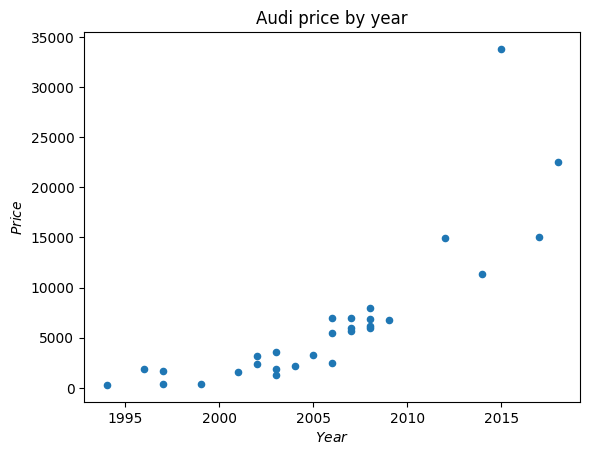

In [66]:
audi_price_plot = pd.DataFrame(audi_sorted_by_year,columns=['Year','Price'])
audi_price_plot.plot(x ='Year', y='Price', kind = 'scatter')
plt.xlabel('$Year$')
plt.ylabel('$Price$')
plt.title('Audi price by year')

# plot by model

In [87]:
audi_model = audi_df.groupby(['Model']).count()
audi_model

,Unnamed: 0,description,url,Year,Volume,Run,Price
Model,,,,,,,
80,1,1,1,1,1,1,1
A3,6,6,6,6,6,6,6
A4,9,9,9,9,9,9,9
A6,7,7,7,7,7,7,7
A8,2,2,2,2,2,2,2
Allroad,1,1,1,1,1,1,1
Cabriolet,1,1,1,1,1,1,1
Q7,2,2,2,2,2,2,2
Quattro,1,1,1,1,1,1,0


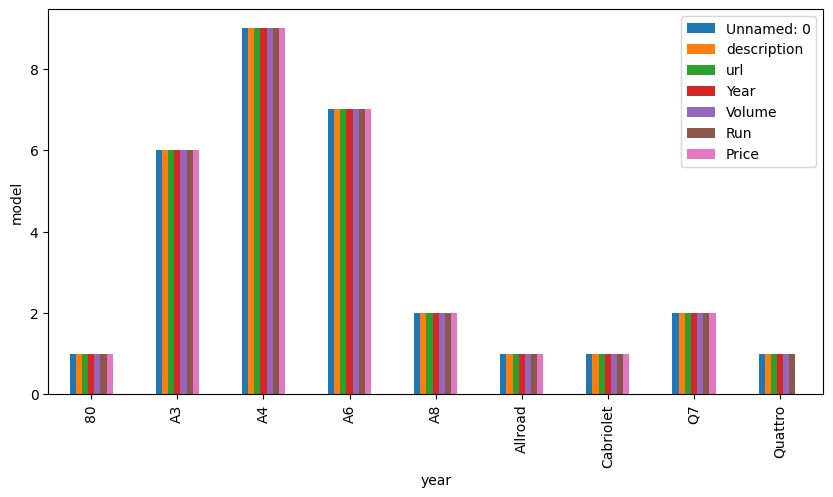

In [80]:
ax = audi_model.plot(kind='bar', figsize=(10,5))
ax.set(xlabel="year", ylabel="model")
ax.yaxis.set_major_formatter(ticker.EngFormatter())